
Processing file: Sparse82.txt
Number of nodes created: 82
Greedy Heuristic Results:
Results: [228.66343999999995, 228.66343999999995, 228.66343999999995, 228.66343999999995, 228.66343999999995, 228.66343999999995, 228.66343999999995, 228.66343999999995, 228.66343999999995, 228.66343999999995]
Best: 228.66343999999995
Average: 228.66343999999995
Standard Deviation: 0.0
Average Time: 0.0006571054458618164 seconds

Hill Climbing Results:
Results: [864.9198839999998, 864.9198839999998, 864.9198839999998, 864.9198839999998, 864.9198839999998, 864.9198839999998, 864.9198839999998, 864.9198839999998, 864.9198839999998, 864.9198839999998]
Best: 864.9198839999998
Average: 864.9198839999998
Standard Deviation: 0.0
Average Time: 3.3928339004516603 seconds

Beam Search Results:
Results: [593.5959959999999, 593.5959959999999, 593.5959959999999, 593.5959959999999, 593.5959959999999, 593.5959959999999, 593.5959959999999, 593.5959959999999, 593.5959959999999, 593.5959959999999]
Best: 593.595995999999

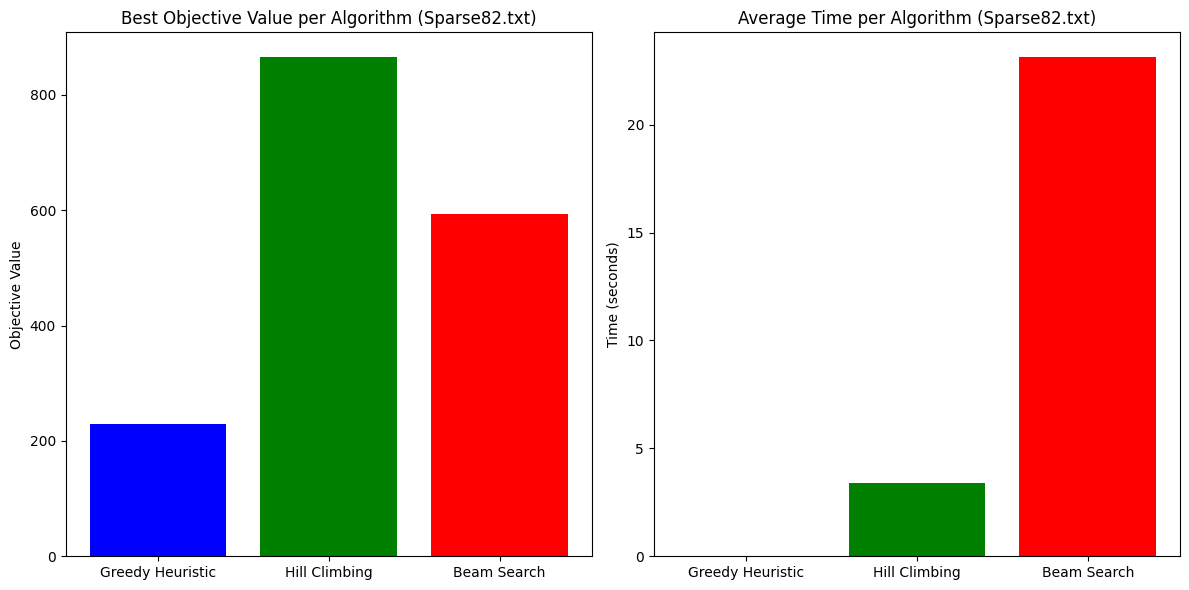


Processing file: RanReal480.txt
Number of nodes created: 480


In [ ]:
import random
import time
import statistics
import copy
import math
import heapq
import matplotlib.pyplot as plt
import seaborn as sns

def read_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    first_line = lines[0].split()
    M = int(first_line[0])
    C = int(first_line[1])

    # Find the index of 'W' in the first line
    w_index = first_line.index('W')

    cluster_limits = [int(x) for x in first_line[2:w_index]]
    node_weights = [int(x) for x in first_line[w_index+1:]]

    edges = []
    for line in lines[1:]:
        if len(line.split()) == 3:
            node1, node2, weight = line.split()
            edges.append((int(node1), int(node2), float(weight)))

    return M, C, cluster_limits, node_weights, edges


def create_graph(M, node_weights, edges):
    graph = {
        'nodes': list(range(M)),
        'edges': [(e[0], e[1]) for e in edges],
        'node_weights': {i: w for i, w in enumerate(node_weights)},
        'edge_weights': {(e[0], e[1]): e[2] for e in edges}
    }
    print(f"Number of nodes created: {len(graph['nodes'])}")
    return graph

def add_node_weight(graph, node, weight):
    graph['node_weights'][node] = weight

def add_edge_weight(graph, node1, node2, weight):
    graph['edge_weights'][(node1, node2)] = weight
    graph['edge_weights'][(node2, node1)] = weight

def calculate_objective(graph, clusters):
    objective_value = 0
    for cluster in clusters:
        for i in range(len(cluster)):
            for j in range(i + 1, len(cluster)):
                edge = (cluster[i], cluster[j])
                if edge in graph['edge_weights']:
                    objective_value += graph['edge_weights'][edge]
    return objective_value

def greedy_heuristic(graph, p, L, U):
    sorted_nodes = sorted(graph['nodes'], key=lambda x: graph['node_weights'][x], reverse=True)
    clusters = [[] for _ in range(p)]
    cluster_weights = [0] * p

    for node in sorted_nodes:
        best_cluster = -1
        best_increase = -1

        for i in range(p):
            if cluster_weights[i] + graph['node_weights'][node] <= U:
                increase = sum(graph['edge_weights'].get((node, n), 0) for n in clusters[i])
                if increase > best_increase:
                    best_increase = increase
                    best_cluster = i

        if best_cluster != -1:
            clusters[best_cluster].append(node)
            cluster_weights[best_cluster] += graph['node_weights'][node]
        else:
            least_weighted = min(range(p), key=lambda i: cluster_weights[i])
            clusters[least_weighted].append(node)
            cluster_weights[least_weighted] += graph['node_weights'][node]

    for i in range(p):
        while cluster_weights[i] < L and len(clusters[i]) > 0:
            for j in range(p):
                if i != j and cluster_weights[j] > L:
                    node = clusters[j].pop()
                    clusters[i].append(node)
                    weight = graph['node_weights'][node]
                    cluster_weights[i] += weight
                    cluster_weights[j] -= weight
                    if cluster_weights[i] >= L:
                        break
            if cluster_weights[i] >= L:
                break

    return clusters

def hill_climbing(graph, initial_clusters, L, U, max_iterations=10):
    current_clusters = copy.deepcopy(initial_clusters)
    current_objective = calculate_objective(graph, current_clusters)

    for _ in range(max_iterations):
        improved = False
        for i in range(len(current_clusters)):
            for j in range(i + 1, len(current_clusters)):
                for node_i in current_clusters[i][:]:
                    for node_j in current_clusters[j][:]:
                        new_clusters = copy.deepcopy(current_clusters)
                        if node_i in new_clusters[i] and node_j in new_clusters[j]:
                            new_clusters[i].remove(node_i)
                            new_clusters[j].remove(node_j)
                            new_clusters[i].append(node_j)
                            new_clusters[j].append(node_i)

                            weight_i = sum(graph['node_weights'][n] for n in new_clusters[i])
                            weight_j = sum(graph['node_weights'][n] for n in new_clusters[j])

                            if L <= weight_i <= U and L <= weight_j <= U:
                                new_objective = calculate_objective(graph, new_clusters)
                                if new_objective > current_objective:
                                    current_clusters = new_clusters
                                    current_objective = new_objective
                                    improved = True

        if not improved:
            break

    return current_clusters

def beam_search(graph, initial_clusters, L, U, beam_width=5, max_iterations=10):
    def generate_neighbors(clusters):
        neighbors = []
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                for node_i in clusters[i]:
                    for node_j in clusters[j]:
                        new_clusters = copy.deepcopy(clusters)
                        new_clusters[i].remove(node_i)
                        new_clusters[j].remove(node_j)
                        new_clusters[i].append(node_j)
                        new_clusters[j].append(node_i)

                        weight_i = sum(graph['node_weights'][n] for n in new_clusters[i])
                        weight_j = sum(graph['node_weights'][n] for n in new_clusters[j])

                        if L <= weight_i <= U and L <= weight_j <= U:
                            neighbors.append(new_clusters)
        return neighbors

    current_beam = [initial_clusters]
    best_clusters = initial_clusters
    best_objective = calculate_objective(graph, initial_clusters)

    for _ in range(max_iterations):
        all_neighbors = []
        for clusters in current_beam:
            all_neighbors.extend(generate_neighbors(clusters))

        if not all_neighbors:
            break

        all_neighbors.sort(key=lambda x: calculate_objective(graph, x), reverse=True)
        current_beam = all_neighbors[:beam_width]

        current_best = max(current_beam, key=lambda x: calculate_objective(graph, x))
        current_best_objective = calculate_objective(graph, current_best)

        if current_best_objective > best_objective:
            best_clusters = current_best
            best_objective = current_best_objective

    return best_clusters

def run_experiment(graph, p, L, U, num_runs=10):
    gh_results = []
    hc_results = []
    bs_results = []
    gh_times = []
    hc_times = []
    bs_times = []

    for _ in range(num_runs):
        gh_start = time.time()
        gh_solution = greedy_heuristic(graph, p, L, U)
        gh_end = time.time()
        gh_results.append(calculate_objective(graph, gh_solution))
        gh_times.append(gh_end - gh_start)

        hc_start = time.time()
        hc_solution = hill_climbing(graph, gh_solution, L, U)
        hc_end = time.time()
        hc_results.append(calculate_objective(graph, hc_solution))
        hc_times.append(hc_end - hc_start)

        bs_start = time.time()
        bs_solution = beam_search(graph, gh_solution, L, U)
        bs_end = time.time()
        bs_results.append(calculate_objective(graph, bs_solution))
        bs_times.append(bs_end - bs_start)

    return gh_results, hc_results, bs_results, gh_times, hc_times, bs_times

# Main execution
file_names = ["Sparse82.txt", "RanReal480.txt"]

for file_name in file_names:
    print(f"\nProcessing file: {file_name}")
    M, C, cluster_limits, node_weights, edges = read_file(file_name)
    graph = create_graph(M, node_weights, edges)

    p = C
    L = cluster_limits[0]
    U = cluster_limits[1]

    gh_results, hc_results, bs_results, gh_times, hc_times, bs_times = run_experiment(graph, p, L, U)

    print("Greedy Heuristic Results:")
    print(f"Results: {gh_results}")
    print(f"Best: {max(gh_results)}")
    print(f"Average: {statistics.mean(gh_results)}")
    print(f"Standard Deviation: {statistics.stdev(gh_results)}")
    print(f"Average Time: {statistics.mean(gh_times)} seconds")

    print("\nHill Climbing Results:")
    print(f"Results: {hc_results}")
    print(f"Best: {max(hc_results)}")
    print(f"Average: {statistics.mean(hc_results)}")
    print(f"Standard Deviation: {statistics.stdev(hc_results)}")
    print(f"Average Time: {statistics.mean(hc_times)} seconds")

    print("\nBeam Search Results:")
    print(f"Results: {bs_results}")
    print(f"Best: {max(bs_results)}")
    print(f"Average: {statistics.mean(bs_results)}")
    print(f"Standard Deviation: {statistics.stdev(bs_results)}")
    print(f"Average Time: {statistics.mean(bs_times)} seconds")

    # Plotting results using matplotlib
    algorithms = ['Greedy Heuristic', 'Hill Climbing', 'Beam Search']

    plt.figure(figsize=(12, 6))

    # Objective values plot
    plt.subplot(1, 2, 1)
    plt.bar(algorithms, [max(gh_results), max(hc_results), max(bs_results)], color=['blue', 'green', 'red'])
    plt.title(f'Best Objective Value per Algorithm ({file_name})')
    plt.ylabel('Objective Value')

    # Time plot
    plt.subplot(1, 2, 2)
    plt.bar(algorithms, [statistics.mean(gh_times), statistics.mean(hc_times), statistics.mean(bs_times)], color=['blue', 'green', 'red'])
    plt.title(f'Average Time per Algorithm ({file_name})')
    plt.ylabel('Time (seconds)')

    plt.tight_layout()
    plt.show()


# New Section

# New Section

MessageError: Error: credential propagation was unsuccessful